In [1]:
import pandas as pd
import json
import re
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTE
from sentence_transformers import SentenceTransformer

/Users/pathipanchongkul/spider_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# -----------------------
# 1. ฟังก์ชัน Extract SQL Features (Handcrafted)
# -----------------------
def extract_sql_features(sql):
    sql = sql.upper()
    features = {}

    keywords = [
        'SELECT', 'FROM', 'WHERE', 'JOIN', 'INNER JOIN', 'LEFT JOIN', 'RIGHT JOIN',
        'GROUP BY', 'HAVING', 'ORDER BY', 'LIMIT', 'COUNT', 'SUM', 'AVG', 'MAX', 'MIN',
        'WITH', 'RANK', 'ROW_NUMBER', 'PARTITION BY'
    ]
    for keyword in keywords:
        features[f'count_{keyword.lower().replace(" ", "_")}'] = len(re.findall(r'\b' + keyword + r'\b', sql))
    
    features['has_subquery'] = 1 if re.search(r'\(.*?SELECT.*?\)', sql, flags=re.DOTALL) else 0

    subqueries = re.findall(r'\(([^()]*(SELECT)[^()]*)\)', sql)
    features['nested_query_depth'] = len(subqueries)

    features['word_count'] = len(sql.split())
    features['char_count'] = len(sql)

    table_matches = re.findall(r'\bFROM\s+(\w+)|JOIN\s+(\w+)', sql)
    tables = set([match[0] or match[1] for match in table_matches if match[0] or match[1]])
    features['table_count'] = len(tables)

    select_clause = re.search(r'SELECT\s+(.*?)\s+FROM', sql, re.IGNORECASE | re.DOTALL)
    if select_clause:
        columns = select_clause.group(1).split(',')
        features['column_count'] = len([col for col in columns if col.strip()])
    else:
        features['column_count'] = 0

    features['has_distinct'] = 1 if 'DISTINCT' in sql else 0

    agg_funcs = ['COUNT', 'SUM', 'AVG', 'MAX', 'MIN']
    features['aggregation_count'] = sum(len(re.findall(r'\b' + func + r'\b', sql)) for func in agg_funcs)

    features['condition_count'] = len(re.findall(r'\b(AND|OR)\b', sql))

    features['has_case_when'] = 1 if re.search(r'CASE\s+WHEN', sql) else 0

    return features

In [3]:
# -----------------------
# 2. โหลดข้อมูล JSON เข้า DataFrame
# -----------------------
with open('../bird/data/dev/dev_j2c2j.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.DataFrame(data)[['SQL', 'question', 'difficulty']]
difficulty_map = {'simple': 0, 'moderate': 1, 'challenging': 2}
df['difficulty_label'] = df['difficulty'].map(difficulty_map)

# -----------------------
# 3. สร้าง Handcrafted Features จาก SQL
# -----------------------
feature_list = df['SQL'].apply(extract_sql_features)
feature_df = pd.DataFrame(feature_list.tolist())

# -----------------------
# 4. แบ่งข้อมูล Train/Test
# -----------------------
X = df[['SQL', 'question']]
y = df['difficulty_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_indices = X_train.index
test_indices = X_test.index
feature_train = feature_df.loc[train_indices]
feature_test = feature_df.loc[test_indices]

# -----------------------
# 5. Scale Handcrafted Features
# -----------------------
scaler = StandardScaler()
feature_train_scaled = scaler.fit_transform(feature_train)
feature_test_scaled = scaler.transform(feature_test)

# -----------------------
# 6. Encode question และ SQL ด้วย MiniLM + ลดมิติด้วย SVD
# -----------------------
em_model = "sentence-transformers/all-MiniLM-L6-v2"
embedder = SentenceTransformer(em_model)

print(f"Encoding question with {em_model}...")
question_train_embeddings = embedder.encode(X_train['question'].tolist(), normalize_embeddings=True)
question_test_embeddings = embedder.encode(X_test['question'].tolist(), normalize_embeddings=True)

svd = TruncatedSVD(n_components=50, random_state=42)  # ลดเหลือ 50 มิติ
question_train_reduced = svd.fit_transform(question_train_embeddings)
question_test_reduced = svd.transform(question_test_embeddings)

print(f"Encoding SQL with {em_model}...")
sql_train_embeddings = embedder.encode(X_train['SQL'].tolist(), show_progress_bar=True)
sql_test_embeddings = embedder.encode(X_test['SQL'].tolist(), show_progress_bar=True)

svd_sql = TruncatedSVD(n_components=50, random_state=42)
sql_train_reduced = svd_sql.fit_transform(sql_train_embeddings)
sql_test_reduced = svd_sql.transform(sql_test_embeddings)

# -----------------------
# 7. รวม Features ทั้งหมดเป็น matrix เดียว
# -----------------------
handcrafted_cols = [f"f_handcrafted_{i}" for i in range(feature_train_scaled.shape[1])]
question_cols = [f"f_question_{i}" for i in range(question_train_reduced.shape[1])]
sql_cols = [f"f_sql_{i}" for i in range(sql_train_reduced.shape[1])]

X_train_combined = pd.DataFrame(
    np.hstack([feature_train_scaled, question_train_reduced, sql_train_reduced]),
    columns=handcrafted_cols + question_cols + sql_cols,
    index=X_train.index
)

X_test_combined = pd.DataFrame(
    np.hstack([feature_test_scaled, question_test_reduced, sql_test_reduced]),
    columns=handcrafted_cols + question_cols + sql_cols,
    index=X_test.index
)

# -----------------------
# 8. Train LightGBM Model
# -----------------------
model = LGBMClassifier(
    class_weight='balanced',
    random_state=42,
    learning_rate=0.1,
    max_depth=8,
    n_estimators=200,
    num_leaves=64,
    verbose=-1
)

Encoding question with sentence-transformers/all-MiniLM-L6-v2...
Encoding SQL with sentence-transformers/all-MiniLM-L6-v2...


Batches: 100%|██████████| 10/10 [00:01<00:00,  9.36it/s]


# Baseline

Training LightGBM model...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test Accuracy: 0.8143322475570033
Test F1 (weighted): 0.8155943704152784
Confusion Matrix:
 [[162  23   0]
 [ 18  70   5]
 [  0  11  18]]
classification Report:
               precision    recall  f1-score   support

      simple       0.90      0.88      0.89       185
    moderate       0.67      0.75      0.71        93
 challenging       0.78      0.62      0.69        29

    accuracy                           0.81       307
   macro avg       0.79      0.75      0.76       307
weighted avg       0.82      0.81      0.82       307



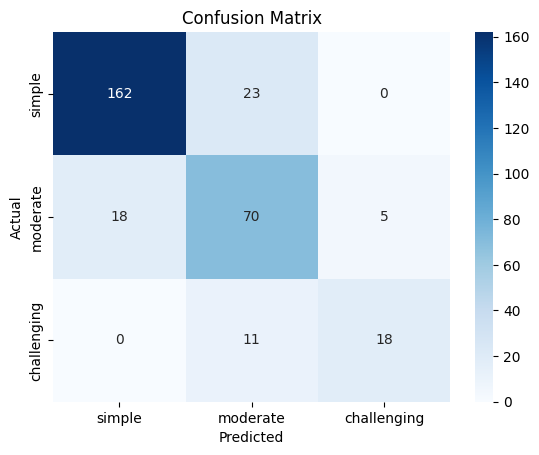

In [4]:
print("Training LightGBM model...")
model.fit(X_train_combined, y_train)
y_pred = model.predict(X_test_combined)

# -----------------------
# 9. Evaluation
# -----------------------
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1 (weighted):", f1_score(y_test, y_pred, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("classification Report:\n", classification_report(y_test, y_pred, target_names=['simple', 'moderate', 'challenging']))

labels = ['simple', 'moderate', 'challenging']
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# SMOTE

Before SMOTE: [740 371 116]
After SMOTE: [740 740 740]


/Users/pathipanchongkul/spider_env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Test Accuracy: 0.7947882736156352
Test F1 (weighted): 0.7964094768233332
Confusion Matrix:
 [[159  25   1]
 [ 21  65   7]
 [  0   9  20]]
classification Report:
               precision    recall  f1-score   support

      simple       0.88      0.86      0.87       185
    moderate       0.66      0.70      0.68        93
 challenging       0.71      0.69      0.70        29

    accuracy                           0.79       307
   macro avg       0.75      0.75      0.75       307
weighted avg       0.80      0.79      0.80       307



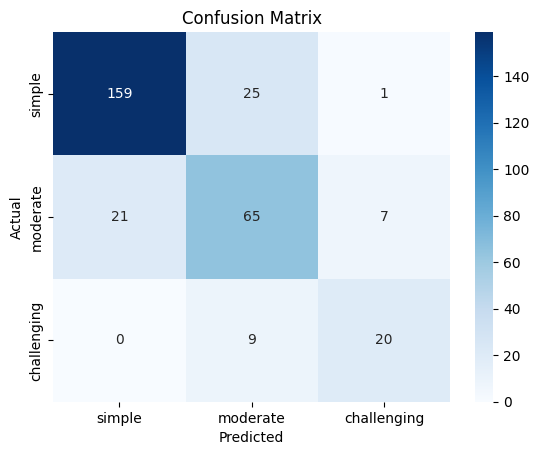

In [5]:
print("Before SMOTE:", np.bincount(y_train))

X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train_combined, y_train)

print("After SMOTE:", np.bincount(y_train_resampled))

model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test_combined)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1 (weighted):", f1_score(y_test, y_pred, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("classification Report:\n", classification_report(y_test, y_pred, target_names=['simple', 'moderate', 'challenging']))

labels = ['simple', 'moderate', 'challenging']
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# SMOTE: Class 2

Before SMOTE: [740 371 116]
After SMOTE: [740 371 500]


/Users/pathipanchongkul/spider_env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Test Accuracy: 0.8078175895765473
Test F1 (weighted): 0.8081469780085488
Confusion Matrix:
 [[163  21   1]
 [ 21  65   7]
 [  0   9  20]]
classification Report:
               precision    recall  f1-score   support

      simple       0.89      0.88      0.88       185
    moderate       0.68      0.70      0.69        93
 challenging       0.71      0.69      0.70        29

    accuracy                           0.81       307
   macro avg       0.76      0.76      0.76       307
weighted avg       0.81      0.81      0.81       307



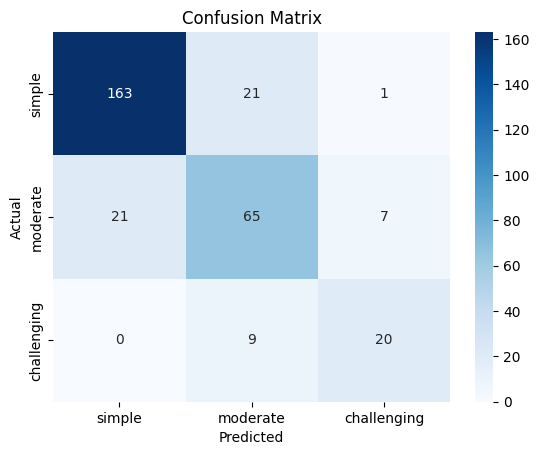

In [6]:
# 1. ดูจำนวนของแต่ละ class ใน training set
print("Before SMOTE:", np.bincount(y_train))

# 2. เลือก oversample เฉพาะ class 2 (challenging)
target_count = 500
smote = SMOTE(sampling_strategy={2: target_count}, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_combined, y_train)

print("After SMOTE:", np.bincount(y_train_smote))

model.fit(X_train_smote, y_train_smote)
y_pred = model.predict(X_test_combined)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1 (weighted):", f1_score(y_test, y_pred, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("classification Report:\n", classification_report(y_test, y_pred, target_names=['simple', 'moderate', 'challenging']))

labels = ['simple', 'moderate', 'challenging']
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# GridsearchCV

In [7]:
# พารามิเตอร์ครอบคลุมจาก baseline และเพิ่มความยืดหยุ่นบางจุด
param_grid = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [6, 8, 10],
    'n_estimators': [100, 200],
    'num_leaves': [31, 64],
    'class_weight': ['balanced'],
}

# สร้าง model base
base_model = LGBMClassifier(random_state=42, verbose=-1)

# สร้าง GridSearchCV
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=0
)

# Train บน training data
print("Starting GridSearch...")
grid_search.fit(X_train_combined, y_train)

# Evaluate บน test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_combined)

print("\nBest Parameters:", grid_search.best_params_)
print("Best CV F1 Score:", grid_search.best_score_)

print("\nEvaluation on Test Set")
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1 (weighted):", f1_score(y_test, y_pred, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['simple', 'moderate', 'challenging']))

Starting GridSearch...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Best Parameters: {'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 31}
Best CV F1 Score: 0.7797088521198934

Evaluation on Test Set
Test Accuracy: 0.7882736156351792
Test F1 (weighted): 0.7887186755698826
Confusion Matrix:
 [[160  25   0]
 [ 21  66   6]
 [  1  12  16]]
Classification Report:
               precision    recall  f1-score   support

      simple       0.88      0.86      0.87       185
    moderate       0.64      0.71      0.67        93
 challenging       0.73      0.55      0.63        29

    accuracy                           0.79       307
   macro avg       0.75      0.71      0.72       307
weighted avg       0.79      0.79      0.79       307

